In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/dataset/gait-in-parkinsons-disease-1.0.0.zip -d /content/dataset

Archive:  /content/drive/MyDrive/Colab_Notebooks/dataset/gait-in-parkinsons-disease-1.0.0.zip
replace /content/dataset/gait-in-parkinsons-disease-1.0.0/demographics.html? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/dataset/gait-in-parkinsons-disease-1.0.0/demographics.html  
  inflating: /content/dataset/gait-in-parkinsons-disease-1.0.0/demographics.txt  
  inflating: /content/dataset/gait-in-parkinsons-disease-1.0.0/demographics.xls  
  inflating: /content/dataset/gait-in-parkinsons-disease-1.0.0/format.txt  
  inflating: /content/dataset/gait-in-parkinsons-disease-1.0.0/GaCo01_01.txt  
  inflating: /content/dataset/gait-in-parkinsons-disease-1.0.0/GaCo02_01.txt  
  inflating: /content/dataset/gait-in-parkinsons-disease-1.0.0/GaCo02_02.txt  
  inflating: /content/dataset/gait-in-parkinsons-disease-1.0.0/GaCo03_01.txt  
  inflating: /content/dataset/gait-in-parkinsons-disease-1.0.0/GaCo03_02.txt  
  inflating: /content/dataset/gait-in-parkinsons-disease-1.0.0/GaCo04_0

In [ ]:
# ✅ Set dataset folder path (Update if needed)
DATASET_FOLDER = "/content/dataset/gait-in-parkinsons-disease-1.0.0"

# ✅ Get all .txt files (ignore metadata files)
file_names = [
    f for f in os.listdir(DATASET_FOLDER)
    if f.endswith('.txt') and not f.startswith(('demographics', 'format'))
]

print(f"Found {len(file_names)} data files ✅")


Found 307 data files ✅


In [ ]:
# ✅ Filter only gait data files (Ignore SHA256SUMS.txt & metadata)
file_paths = [
    os.path.join(DATASET_FOLDER, f) for f in file_names
    if f.endswith(".txt") and not f.startswith(("SHA256SUMS", "demographics", "format"))
]

# ✅ Ensure labels are correctly assigned
labels = []
for f in file_names:
    if f.endswith(".txt") and not f.startswith(("SHA256SUMS", "demographics", "format")):
        if "Co" in f:
            labels.append(0)  # Control
        elif "Pt" in f:
            labels.append(1)  # Parkinson's

# ✅ Check if file_paths and labels have the same length
print(f"✅ Total Valid Gait Files: {len(file_paths)}, Labels: {len(labels)}")


✅ Total Valid Gait Files: 306, Labels: 306


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# ✅ Set dataset folder path
DATASET_FOLDER = "/content/dataset/gait-in-parkinsons-disease-1.0.0"

# ✅ Get all .txt files (ignore metadata files)
file_names = [
    f for f in os.listdir(DATASET_FOLDER)
    if f.endswith('.txt') and not f.startswith(('demographics', 'format'))
]

print(f"✅ Found {len(file_names)} valid gait data files")

# ✅ Load & Normalize Data
data_list = []
scaler = MinMaxScaler()

for file_name in file_names:
    file_path = os.path.join(DATASET_FOLDER, file_name)

    # Load and normalize
    try:
        df = pd.read_csv(file_path, sep="\s+", header=None, engine="python")
        if df.shape[1] == 19:
            df = df.iloc[:, 1:]  # Remove time column
            normalized_data = scaler.fit_transform(df)
            data_list.append(normalized_data)
    except Exception as e:
        print(f"Skipping {file_name}: {e}")

print(f"✅ Successfully loaded {len(data_list)} sequences")


✅ Found 307 valid gait data files
✅ Successfully loaded 306 sequences


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# ✅ Define Fixed Length for Padding
MAX_TIME_STEPS = 500  # CNN requires fixed sequence length
NUM_FEATURES = 18  # 18 force sensor values per time step

# ✅ Initialize Zero Padded Array
X_padded = np.zeros((len(file_paths), MAX_TIME_STEPS, NUM_FEATURES))

# ✅ Pad or Truncate Each Sequence
for i, seq in enumerate(data_list):
    seq_length = min(len(seq), MAX_TIME_STEPS)  # Use min to handle shorter sequences
    X_padded[i, :seq_length, :] = seq[:seq_length, :]  # Pad or truncate

print(f"✅ Data Padded: {X_padded.shape}")  # (samples, time_steps, features)


✅ Data Padded: (306, 500, 18)


In [ ]:
# ✅ Normalize Data Using MinMaxScaler
scaler = MinMaxScaler()
X_reshaped = X_padded.reshape(-1, NUM_FEATURES)  # Flatten before scaling
X_normalized = scaler.fit_transform(X_reshaped).reshape(X_padded.shape)

print(f"✅ Data Normalized: {X_normalized.shape}")


✅ Data Normalized: (306, 500, 18)


In [ ]:
from sklearn.model_selection import train_test_split

# ✅ Perform Train-Test Split (Stratified to Balance Labels)
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"✅ Train: {X_train.shape}, Test: {X_test.shape}")


✅ Train: (244, 500, 18), Test: (62, 500, 18)


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# ✅ Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# ✅ Create DataLoaders for Training
BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ PyTorch DataLoaders Ready! Batch Size: {BATCH_SIZE}")


✅ PyTorch DataLoaders Ready! Batch Size: 32


In [ ]:
import torch.nn as nn
import torch.optim as optim

# ✅ Define the 5-Layer CNN Model
class ParkinsonsCNN(nn.Module):
    def __init__(self):
        super(ParkinsonsCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=18, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm1d(256)
        self.pool5 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 15, 128)  # Adjust based on output size
        self.dropout1 = nn.Dropout(0.5)  # Dropout to prevent overfitting
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 2)  # Output layer (PD vs Control)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))
        x = self.pool5(self.relu(self.bn5(self.conv5(x))))

        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # No softmax (CrossEntropyLoss includes it)
        return x


In [ ]:
# ✅ Set Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Initialize Model
model = ParkinsonsCNN().to(device)

# ✅ Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()  # Since it's a classification task
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("✅ CNN Model Ready!")


✅ CNN Model Ready!


In [ ]:
# ✅ Training Function
def train_model(model, train_loader, epochs=20):
    model.train()

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs.permute(0, 2, 1))  # Change shape for Conv1D
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Accuracy: {accuracy:.2f}%")

# ✅ Train CNN
train_model(model, train_loader, epochs=20)


Epoch 1/20 | Loss: 5.8303 | Accuracy: 62.70%
Epoch 2/20 | Loss: 5.1499 | Accuracy: 62.30%
Epoch 3/20 | Loss: 4.2277 | Accuracy: 72.13%
Epoch 4/20 | Loss: 3.5708 | Accuracy: 77.87%
Epoch 5/20 | Loss: 3.2482 | Accuracy: 84.43%
Epoch 6/20 | Loss: 3.1025 | Accuracy: 82.79%
Epoch 7/20 | Loss: 2.8230 | Accuracy: 86.07%
Epoch 8/20 | Loss: 2.7044 | Accuracy: 87.30%
Epoch 9/20 | Loss: 2.0596 | Accuracy: 89.34%
Epoch 10/20 | Loss: 1.7434 | Accuracy: 92.21%
Epoch 11/20 | Loss: 2.6238 | Accuracy: 86.07%
Epoch 12/20 | Loss: 1.9583 | Accuracy: 91.80%
Epoch 13/20 | Loss: 1.6270 | Accuracy: 93.03%
Epoch 14/20 | Loss: 1.1855 | Accuracy: 94.67%
Epoch 15/20 | Loss: 1.4077 | Accuracy: 92.62%
Epoch 16/20 | Loss: 1.8700 | Accuracy: 92.21%
Epoch 17/20 | Loss: 1.2468 | Accuracy: 93.85%
Epoch 18/20 | Loss: 1.1385 | Accuracy: 94.67%
Epoch 19/20 | Loss: 0.8844 | Accuracy: 95.49%
Epoch 20/20 | Loss: 0.3625 | Accuracy: 99.18%


In [ ]:
# ✅ Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.permute(0, 2, 1))

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"✅ Model Accuracy on Test Data: {accuracy:.2f}%")

# ✅ Evaluate CNN
evaluate_model(model, test_loader)


✅ Model Accuracy on Test Data: 83.87%


Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.58      0.69        19
           1       0.84      0.95      0.89        43

    accuracy                           0.84        62
   macro avg       0.84      0.77      0.79        62
weighted avg       0.84      0.84      0.83        62



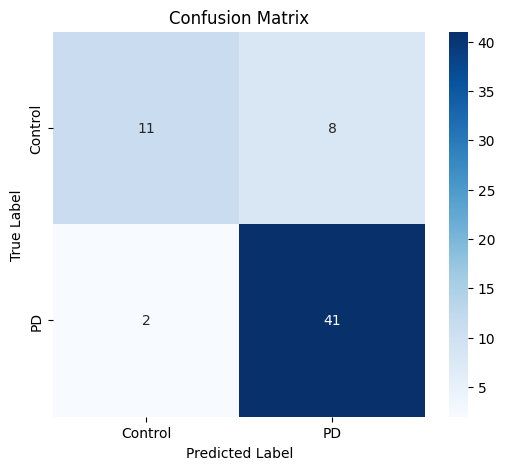

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_metrics(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.permute(0, 2, 1))
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print("Classification Report:\n", classification_report(y_true, y_pred))

    # ✅ Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Control", "PD"], yticklabels=["Control", "PD"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_metrics(model, test_loader)


In [ ]:
#torch.save(model.state_dict(), "parkinsons_cnn.pth")
print("✅ Model Saved!")


✅ Model Saved!


In [ ]:
import torch

# ✅ Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# ✅ Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Data Ready for LSTM! Train: {X_train_tensor.shape}, Test: {X_test_tensor.shape}")


✅ Data Ready for LSTM! Train: torch.Size([244, 500, 18]), Test: torch.Size([62, 500, 18])


In [ ]:
import torch.nn as nn

# ✅ Define 5-Layer LSTM Model
class ParkinsonsLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(ParkinsonsLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Take last time step's output
        return out

# ✅ Model Parameters
input_dim = 18  # Number of gait features
hidden_dim = 128  # Number of LSTM units
num_layers = 5  # Number of stacked LSTM layers
output_dim = 2  # Binary classification (PD vs Control)

# ✅ Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ParkinsonsLSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)

# ✅ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("✅ LSTM Model Ready!")


✅ LSTM Model Ready!


In [ ]:
# ✅ Training Function
def train_lstm(model, train_loader, epochs=20):
    model.train()

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)  # No need to permute for LSTM
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Accuracy: {accuracy:.2f}%")

# ✅ Train LSTM
train_lstm(model, train_loader, epochs=20)


Epoch 1/20 | Loss: 5.2426 | Accuracy: 63.52%
Epoch 2/20 | Loss: 5.1272 | Accuracy: 70.08%
Epoch 3/20 | Loss: 5.0127 | Accuracy: 70.08%
Epoch 4/20 | Loss: 5.0125 | Accuracy: 70.08%
Epoch 5/20 | Loss: 4.9598 | Accuracy: 70.08%
Epoch 6/20 | Loss: 4.8746 | Accuracy: 70.08%
Epoch 7/20 | Loss: 4.9143 | Accuracy: 70.08%
Epoch 8/20 | Loss: 4.9087 | Accuracy: 70.08%
Epoch 9/20 | Loss: 4.9280 | Accuracy: 70.08%
Epoch 10/20 | Loss: 4.8180 | Accuracy: 70.08%
Epoch 11/20 | Loss: 4.7974 | Accuracy: 70.08%
Epoch 12/20 | Loss: 4.6912 | Accuracy: 70.08%
Epoch 13/20 | Loss: 4.3862 | Accuracy: 71.31%
Epoch 14/20 | Loss: 4.6980 | Accuracy: 67.21%
Epoch 15/20 | Loss: 4.7205 | Accuracy: 65.16%
Epoch 16/20 | Loss: 4.6453 | Accuracy: 70.08%
Epoch 17/20 | Loss: 4.6544 | Accuracy: 70.08%
Epoch 18/20 | Loss: 4.6184 | Accuracy: 70.08%
Epoch 19/20 | Loss: 4.6373 | Accuracy: 70.08%
Epoch 20/20 | Loss: 4.6968 | Accuracy: 70.08%


In [ ]:
# ✅ Evaluation Function
def evaluate_lstm(model, test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"✅ Model Accuracy on Test Data: {accuracy:.2f}%")

# ✅ Evaluate LSTM
evaluate_lstm(model, test_loader)


✅ Model Accuracy on Test Data: 69.35%


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import numpy as np

def evaluate_metrics(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Shape: (batch_size, num_classes)

            # **Convert probabilities to class labels**
            predicted = torch.argmax(outputs, dim=1).cpu().numpy()  # Now shape: (batch_size,)
            labels = labels.cpu().numpy()  # Ensure correct shape

            all_preds.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # **🔹 Debugging Step**
    print(f"✅ Fixed Predictions Shape: {all_preds.shape}")
    print(f"✅ Labels Shape: {all_labels.shape}")

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average="binary", zero_division=1)
    recall = recall_score(all_labels, all_preds, average="binary", zero_division=1)
    f1 = f1_score(all_labels, all_preds, average="binary", zero_division=1)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Display results
    print(f"✅ Model Accuracy: {accuracy:.2f}%")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1-score: {f1:.4f}")
    print("✅ Confusion Matrix:\n", conf_matrix)

# Call the function
evaluate_metrics(model, test_loader)


✅ Fixed Predictions Shape: (62,)
✅ Labels Shape: (62,)
✅ Model Accuracy: 69.35%
✅ Precision: 0.6935
✅ Recall: 1.0000
✅ F1-score: 0.8190
✅ Confusion Matrix:
 [[ 0 19]
 [ 0 43]]


In [ ]:
np.save("train_data.npy", X_train)
np.save("train_labels.npy", y_train)
np.save("test_data.npy", X_test)
np.save("test_labels.npy", y_test)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# ✅ Load Data
def load_data():
    train_data = np.load("train_data.npy")
    train_labels = np.load("train_labels.npy")
    test_data = np.load("test_data.npy")
    test_labels = np.load("test_labels.npy")

    train_data, train_labels = torch.tensor(train_data, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.long)
    test_data, test_labels = torch.tensor(test_data, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.long)

    return train_data, train_labels, test_data, test_labels

# ✅ Normalize Data (Min-Max Scaling)
def normalize_data(data):
    mean = data.mean(dim=(0, 1), keepdim=True)
    std = data.std(dim=(0, 1), keepdim=True)
    return (data - mean) / (std + 1e-8)  # Adding epsilon to avoid division by zero

# ✅ CNN Model (5 Layers with LeakyReLU & Xavier Init)
class CNNBranch(nn.Module):
    def __init__(self, input_channels=18):
        super(CNNBranch, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)

        self._initialize_weights()

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = self.pool(x).squeeze(-1)
        return self.dropout(x)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# ✅ LSTM Model (5 Layers, Bidirectional with Orthogonal Init)
class LSTMBranch(nn.Module):
    def __init__(self, input_size=18, hidden_size=128, num_layers=5):
        super(LSTMBranch, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.3)

        self._initialize_weights()

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # Take last two hidden layers (bidirectional)
        return hidden

    def _initialize_weights(self):
        for name, param in self.lstm.named_parameters():
            if "weight_hh" in name:
                nn.init.orthogonal_(param)
            elif "weight_ih" in name:
                nn.init.xavier_uniform_(param)
            elif "bias" in name:
                nn.init.zeros_(param)

# ✅ Fusion Model (CNN + LSTM)
class CNNLSTMModel(nn.Module):
    def __init__(self, input_channels=18, lstm_hidden=128, num_classes=2):
        super(CNNLSTMModel, self).__init__()
        self.cnn_branch = CNNBranch(input_channels)
        self.lstm_branch = LSTMBranch(input_size=input_channels, hidden_size=lstm_hidden)
        self.fc = nn.Linear(512 + (2 * lstm_hidden), num_classes)

    def forward(self, x):
        x_cnn = self.cnn_branch(x.permute(0, 2, 1))  # (N, C, L) for CNN
        x_lstm = self.lstm_branch(x)  # (N, H)
        fused = torch.cat((x_cnn, x_lstm), dim=1)
        return self.fc(fused)

# ✅ Training Function (Using Cosine Annealing LR + Label Smoothing)
def train_model(model, train_loader, epochs=30):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)  # Smooth decay
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Helps with noisy labels

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Accuracy: {accuracy:.2f}% | LR: {scheduler.get_last_lr()[0]:.6f}")

    torch.save(model.state_dict(), "gait_cnn_lstm_optimized.pth")
    print("✅ Model Saved: gait_cnn_lstm_optimized.pth")

# ✅ Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"✅ Model Accuracy on Test Data: {accuracy:.2f}%")

# ✅ Main Script
if __name__ == "__main__":
    train_data, train_labels, test_data, test_labels = load_data()
    train_data, test_data = normalize_data(train_data), normalize_data(test_data)

    train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=32, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNNLSTMModel().to(device)

    train_model(model, train_loader, epochs=30)
    evaluate_model(model, test_loader)


Epoch 1/30 | Loss: 5.3158 | Accuracy: 70.08% | LR: 0.000488
Epoch 2/30 | Loss: 5.0245 | Accuracy: 70.08% | LR: 0.000453
Epoch 3/30 | Loss: 4.8820 | Accuracy: 70.08% | LR: 0.000399
Epoch 4/30 | Loss: 4.7578 | Accuracy: 70.08% | LR: 0.000331
Epoch 5/30 | Loss: 4.3704 | Accuracy: 73.77% | LR: 0.000255
Epoch 6/30 | Loss: 4.3082 | Accuracy: 76.23% | LR: 0.000179
Epoch 7/30 | Loss: 4.1868 | Accuracy: 78.28% | LR: 0.000111
Epoch 8/30 | Loss: 4.1087 | Accuracy: 75.82% | LR: 0.000057
Epoch 9/30 | Loss: 4.0424 | Accuracy: 77.46% | LR: 0.000022
Epoch 10/30 | Loss: 4.0367 | Accuracy: 77.87% | LR: 0.000010
Epoch 11/30 | Loss: 4.0232 | Accuracy: 77.46% | LR: 0.000022
Epoch 12/30 | Loss: 3.9757 | Accuracy: 78.69% | LR: 0.000057
Epoch 13/30 | Loss: 4.0131 | Accuracy: 78.69% | LR: 0.000111
Epoch 14/30 | Loss: 4.0535 | Accuracy: 78.28% | LR: 0.000179
Epoch 15/30 | Loss: 4.0166 | Accuracy: 76.64% | LR: 0.000255
Epoch 16/30 | Loss: 3.9537 | Accuracy: 78.28% | LR: 0.000331
Epoch 17/30 | Loss: 3.8621 | Accu

✅ Classification Report:
              precision    recall  f1-score   support

     Class 0       0.67      0.63      0.65        19
     Class 1       0.84      0.86      0.85        43

    accuracy                           0.79        62
   macro avg       0.75      0.75      0.75        62
weighted avg       0.79      0.79      0.79        62



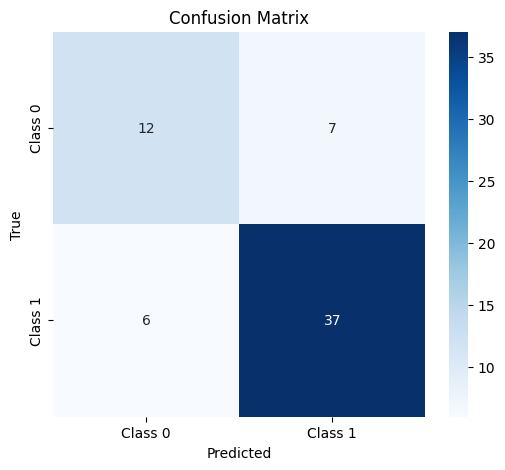

In [ ]:
# ✅ Evaluation Metrics (Accuracy, Precision, Recall, F1, Confusion Matrix)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def detailed_evaluation(model, test_loader, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("✅ Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage (change class_names if needed):
class_names = ['Class 0', 'Class 1']
detailed_evaluation(model, test_loader, class_names)


In [ ]:
import torch
import torch.nn as nn

# Define the Autoencoder with a 1-layer CNN in the Encoder
class GaitAutoencoder(nn.Module):
    def __init__(self, input_dim=18, hidden_dim=64, encoded_dim=12):
        super(GaitAutoencoder, self).__init__()

        # Encoder part: 1-layer CNN to extract features
        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1),  # 1-layer CNN
            nn.ReLU(),  # Activation function
            nn.Conv1d(hidden_dim, encoded_dim, kernel_size=3, padding=1),  # Reduces dimension
            nn.ReLU()  # Activation function
        )

        # Decoder part: Reconstruction of original input
        self.decoder = nn.Sequential(
            nn.Conv1d(encoded_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, input_dim, kernel_size=3, padding=1),
        )

    def forward(self, x):
        # Forward pass: Encoding and then Decoding
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        # Only encode part (for compressed data)
        return self.encoder(x)


In [ ]:
import torch.optim as optim

# Create the model and move it to the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = GaitAutoencoder(input_dim=18, hidden_dim=64, encoded_dim=12).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the Autoencoder
def train_autoencoder(model, data, epochs=10, batch_size=32):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        # Load data as torch tensors
        inputs = torch.tensor(data).permute(0, 2, 1).float().to(device)  # (N, 500, 18) -> (N, 18, 500)

        # Create mini-batches
        for i in range(0, len(inputs), batch_size):
            batch_inputs = inputs[i:i+batch_size]

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_inputs)

            # Compute loss
            loss = criterion(outputs, batch_inputs)

            # Backpropagation
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")

# Call the training function
train_autoencoder(autoencoder, X_padded, epochs=10, batch_size=32)


Epoch [1/10], Loss: 1.3192
Epoch [2/10], Loss: 0.8074
Epoch [3/10], Loss: 0.5417
Epoch [4/10], Loss: 0.3580
Epoch [5/10], Loss: 0.2407
Epoch [6/10], Loss: 0.1504
Epoch [7/10], Loss: 0.1161
Epoch [8/10], Loss: 0.1025
Epoch [9/10], Loss: 0.0943
Epoch [10/10], Loss: 0.0882


In [ ]:
with torch.no_grad():
    # Pass the padded data through the encoder to get compressed features
    inputs = torch.tensor(X_padded).permute(0, 2, 1).float().to(device)  # (N, 500, 18) -> (N, 18, 500)
    compressed_data = autoencoder.encode(inputs)  # Shape: (N, encoded_dim, 500)

    # If needed, convert back to numpy array
    compressed_data = compressed_data.permute(0, 2, 1).cpu().numpy()  # (N, 500, encoded_dim)


In [ ]:
# ✅ Normalize Data Using MinMaxScaler
scaler = MinMaxScaler()
X_reshaped = compressed_data.reshape(-1, NUM_FEATURES)  # Flatten before scaling
X_normalized = scaler.fit_transform(X_reshaped).reshape(compressed_data.shape)

print(f"✅ Data Normalized: {X_normalized.shape}")


✅ Data Normalized: (306, 500, 12)


In [ ]:
from sklearn.model_selection import train_test_split

# ✅ Perform Train-Test Split (Stratified to Balance Labels)
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"✅ Train: {X_train.shape}, Test: {X_test.shape}")


✅ Train: (244, 500, 12), Test: (62, 500, 12)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# ✅ Convert to Torch Tensors
train_data = torch.tensor(X_train, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.long)
test_data = torch.tensor(X_test, dtype=torch.float32)
test_labels = torch.tensor(y_test, dtype=torch.long)

# ✅ Create DataLoaders
train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=32, shuffle=False)


In [ ]:
np.save("train_data.npy", X_train)
np.save("train_labels.npy", y_train)
np.save("test_data.npy", X_test)
np.save("test_labels.npy", y_test)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# ✅ Load Data
def load_data():
    train_data = np.load("train_data.npy")
    train_labels = np.load("train_labels.npy")
    test_data = np.load("test_data.npy")
    test_labels = np.load("test_labels.npy")

    train_data, train_labels = torch.tensor(train_data, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.long)
    test_data, test_labels = torch.tensor(test_data, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.long)

    return train_data, train_labels, test_data, test_labels

# ✅ Normalize Data (Min-Max Scaling)
def normalize_data(data):
    mean = data.mean(dim=(0, 1), keepdim=True)
    std = data.std(dim=(0, 1), keepdim=True)
    return (data - mean) / (std + 1e-8)  # Adding epsilon to avoid division by zero

# ✅ CNN Model (5 Layers with LeakyReLU & Xavier Init)
class CNNBranch(nn.Module):
    def __init__(self, input_channels=18):
        super(CNNBranch, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)

        self._initialize_weights()

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = self.pool(x).squeeze(-1)
        return self.dropout(x)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# ✅ LSTM Model (5 Layers, Bidirectional with Orthogonal Init)
class LSTMBranch(nn.Module):
    def __init__(self, input_size=18, hidden_size=128, num_layers=5):
        super(LSTMBranch, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.3)

        self._initialize_weights()

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # Take last two hidden layers (bidirectional)
        return hidden

    def _initialize_weights(self):
        for name, param in self.lstm.named_parameters():
            if "weight_hh" in name:
                nn.init.orthogonal_(param)
            elif "weight_ih" in name:
                nn.init.xavier_uniform_(param)
            elif "bias" in name:
                nn.init.zeros_(param)

# ✅ Fusion Model (CNN + LSTM)
class CNNLSTMModel(nn.Module):
    def __init__(self, input_channels=18, lstm_hidden=128, num_classes=2):
        super(CNNLSTMModel, self).__init__()
        self.cnn_branch = CNNBranch(input_channels)
        self.lstm_branch = LSTMBranch(input_size=input_channels, hidden_size=lstm_hidden)
        self.fc = nn.Linear(512 + (2 * lstm_hidden), num_classes)

    def forward(self, x):
        x_cnn = self.cnn_branch(x.permute(0, 2, 1))  # (N, C, L) for CNN
        x_lstm = self.lstm_branch(x)  # (N, H)
        fused = torch.cat((x_cnn, x_lstm), dim=1)
        return self.fc(fused)

# ✅ Training Function (Using Cosine Annealing LR + Label Smoothing)
def train_model(model, train_loader, epochs=30):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)  # Smooth decay
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Helps with noisy labels

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Accuracy: {accuracy:.2f}% | LR: {scheduler.get_last_lr()[0]:.6f}")

    torch.save(model.state_dict(), "gait_cnn_lstm_optimized_1.pth")
    print("✅ Model Saved: gait_cnn_lstm_optimized_1.pth")

# ✅ Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"✅ Model Accuracy on Test Data: {accuracy:.2f}%")

# ✅ Main Script
if __name__ == "__main__":
    train_data, train_labels, test_data, test_labels = load_data()
    train_data, test_data = normalize_data(train_data), normalize_data(test_data)

    train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=32, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_encoder = CNNLSTMModel(input_channels=train_data.shape[2]).to(device)

    train_model(model_encoder, train_loader, epochs=30)
    evaluate_model(model_encoder, test_loader)


Epoch 1/30 | Loss: 5.1397 | Accuracy: 70.08% | LR: 0.000488
Epoch 2/30 | Loss: 4.9244 | Accuracy: 70.08% | LR: 0.000453
Epoch 3/30 | Loss: 4.7455 | Accuracy: 70.08% | LR: 0.000399
Epoch 4/30 | Loss: 4.6316 | Accuracy: 70.08% | LR: 0.000331
Epoch 5/30 | Loss: 4.4748 | Accuracy: 71.31% | LR: 0.000255
Epoch 6/30 | Loss: 4.4603 | Accuracy: 72.54% | LR: 0.000179
Epoch 7/30 | Loss: 4.3384 | Accuracy: 75.41% | LR: 0.000111
Epoch 8/30 | Loss: 4.3286 | Accuracy: 74.18% | LR: 0.000057
Epoch 9/30 | Loss: 4.2964 | Accuracy: 75.41% | LR: 0.000022
Epoch 10/30 | Loss: 4.3194 | Accuracy: 75.41% | LR: 0.000010
Epoch 11/30 | Loss: 4.3128 | Accuracy: 75.00% | LR: 0.000022
Epoch 12/30 | Loss: 4.2653 | Accuracy: 75.41% | LR: 0.000057
Epoch 13/30 | Loss: 4.3114 | Accuracy: 76.23% | LR: 0.000111
Epoch 14/30 | Loss: 4.3338 | Accuracy: 75.41% | LR: 0.000179
Epoch 15/30 | Loss: 4.3461 | Accuracy: 75.82% | LR: 0.000255
Epoch 16/30 | Loss: 4.2742 | Accuracy: 76.23% | LR: 0.000331
Epoch 17/30 | Loss: 4.3563 | Accu

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# ✅ Load Data
def load_data():
    train_data = np.load("train_data.npy")
    train_labels = np.load("train_labels.npy")
    test_data = np.load("test_data.npy")
    test_labels = np.load("test_labels.npy")

    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    return train_data, train_labels, test_data, test_labels

# ✅ Normalize Data (Min-Max Scaling)
def normalize_data(data):
    mean = data.mean(dim=(0, 1), keepdim=True)
    std = data.std(dim=(0, 1), keepdim=True)
    return (data - mean) / (std + 1e-8)  # epsilon to avoid divide by zero

# ✅ LSTM Encoder (5 Layers, Bidirectional with Orthogonal Init)
class LSTMEncoder(nn.Module):
    def __init__(self, input_size=18, hidden_size=128, num_layers=5):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.3)
        self._initialize_weights()

    def forward(self, x):
        output, _ = self.lstm(x)  # output: (batch, seq_len, hidden_size*2)
        return output

    def _initialize_weights(self):
        for name, param in self.lstm.named_parameters():
            if "weight_hh" in name:
                nn.init.orthogonal_(param)
            elif "weight_ih" in name:
                nn.init.xavier_uniform_(param)
            elif "bias" in name:
                nn.init.zeros_(param)

# ✅ CNN Decoder (5 Layers with LeakyReLU & Xavier Init)
class CNNDecoder(nn.Module):
    def __init__(self, input_channels=256):  # hidden_size * 2 because bidirectional
        super(CNNDecoder, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(512, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(512, 512, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)

        self._initialize_weights()

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = self.pool(x).squeeze(-1)
        return self.dropout(x)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

# ✅ Final Model (LSTM → CNN → FC)
class LSTM_CNN_Model(nn.Module):
    def __init__(self, input_size=18, lstm_hidden=128, num_classes=2):
        super(LSTM_CNN_Model, self).__init__()
        self.lstm_encoder = LSTMEncoder(input_size=input_size, hidden_size=lstm_hidden)
        self.cnn_decoder = CNNDecoder(input_channels=lstm_hidden * 2)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.lstm_encoder(x)          # (batch, seq_len, hidden*2)
        x = x.permute(0, 2, 1)             # (batch, channels, seq_len) for CNN
        x = self.cnn_decoder(x)            # (batch, 512)
        out = self.fc(x)                   # (batch, num_classes)
        return out

# ✅ Training Function (Using Cosine Annealing LR + Label Smoothing)
def train_model(model, train_loader, epochs=30):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Accuracy: {accuracy:.2f}% | LR: {scheduler.get_last_lr()[0]:.6f}")

    torch.save(model.state_dict(), "gait_lstm_cnn_optimized.pth")
    print("✅ Model Saved: gait_lstm_cnn_optimized.pth")

# ✅ Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"✅ Model Accuracy on Test Data: {accuracy:.2f}%")

# ✅ Main Script
if __name__ == "__main__":
    train_data, train_labels, test_data, test_labels = load_data()
    train_data, test_data = normalize_data(train_data), normalize_data(test_data)

    train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=32, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTM_CNN_Model(input_size=train_data.shape[2]).to(device)

    train_model(model, train_loader, epochs=30)
    evaluate_model(model, test_loader)


Epoch 1/30 | Loss: 5.4154 | Accuracy: 70.08% | LR: 0.000488
Epoch 2/30 | Loss: 4.9118 | Accuracy: 70.08% | LR: 0.000453
Epoch 3/30 | Loss: 4.7356 | Accuracy: 70.08% | LR: 0.000399
Epoch 4/30 | Loss: 4.6625 | Accuracy: 70.08% | LR: 0.000331
Epoch 5/30 | Loss: 4.6306 | Accuracy: 71.31% | LR: 0.000255
Epoch 6/30 | Loss: 4.7505 | Accuracy: 75.00% | LR: 0.000179
Epoch 7/30 | Loss: 4.4018 | Accuracy: 77.05% | LR: 0.000111
Epoch 8/30 | Loss: 4.4410 | Accuracy: 75.00% | LR: 0.000057
Epoch 9/30 | Loss: 4.3620 | Accuracy: 75.00% | LR: 0.000022
Epoch 10/30 | Loss: 4.3251 | Accuracy: 75.00% | LR: 0.000010
Epoch 11/30 | Loss: 4.4327 | Accuracy: 75.41% | LR: 0.000022
Epoch 12/30 | Loss: 4.3664 | Accuracy: 75.41% | LR: 0.000057
Epoch 13/30 | Loss: 4.4005 | Accuracy: 75.82% | LR: 0.000111
Epoch 14/30 | Loss: 4.3251 | Accuracy: 75.41% | LR: 0.000179
Epoch 15/30 | Loss: 4.3238 | Accuracy: 76.23% | LR: 0.000255
Epoch 16/30 | Loss: 4.3264 | Accuracy: 77.46% | LR: 0.000331
Epoch 17/30 | Loss: 4.3889 | Accu

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# ✅ Load Data
def load_data():
    train_data = np.load("train_data.npy")
    train_labels = np.load("train_labels.npy")
    test_data = np.load("test_data.npy")
    test_labels = np.load("test_labels.npy")

    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    return train_data, train_labels, test_data, test_labels

# ✅ Normalize Data (Min-Max Scaling)
def normalize_data(data):
    mean = data.mean(dim=(0, 1), keepdim=True)
    std = data.std(dim=(0, 1), keepdim=True)
    return (data - mean) / (std + 1e-8)

# ✅ Fusion Model (CNN + LSTM alternately stacked)
class FusedCNNLSTM(nn.Module):
    def __init__(self, input_channels=18, hidden_size=128, num_classes=2):
        super(FusedCNNLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.lstm1 = nn.LSTM(64, hidden_size, num_layers=1, batch_first=True, bidirectional=True)

        self.conv2 = nn.Conv1d(hidden_size * 2, 128, kernel_size=3, padding=1)
        self.lstm2 = nn.LSTM(128, hidden_size, num_layers=1, batch_first=True, bidirectional=True)

        self.conv3 = nn.Conv1d(hidden_size * 2, 256, kernel_size=3, padding=1)
        self.lstm3 = nn.LSTM(256, hidden_size, num_layers=1, batch_first=True, bidirectional=True)

        self.conv4 = nn.Conv1d(hidden_size * 2, 256, kernel_size=3, padding=1)
        self.lstm4 = nn.LSTM(256, hidden_size, num_layers=1, batch_first=True, bidirectional=True)

        self.conv5 = nn.Conv1d(hidden_size * 2, 512, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, channels, seq_len)

        x = F.leaky_relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # (batch, seq_len, channels)
        x, _ = self.lstm1(x)
        x = x.permute(0, 2, 1)

        x = F.leaky_relu(self.conv2(x))
        x = x.permute(0, 2, 1)
        x, _ = self.lstm2(x)
        x = x.permute(0, 2, 1)

        x = F.leaky_relu(self.conv3(x))
        x = x.permute(0, 2, 1)
        x, _ = self.lstm3(x)
        x = x.permute(0, 2, 1)

        x = F.leaky_relu(self.conv4(x))
        x = x.permute(0, 2, 1)
        x, _ = self.lstm4(x)
        x = x.permute(0, 2, 1)

        x = F.leaky_relu(self.conv5(x))
        x = self.pool(x).squeeze(-1)
        x = self.dropout(x)
        out = self.fc(x)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            if isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.zeros_(param)

# ✅ Training Function (Using Cosine Annealing LR + Label Smoothing)
def train_model(model, train_loader, epochs=30):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Accuracy: {accuracy:.2f}% | LR: {scheduler.get_last_lr()[0]:.6f}")

    torch.save(model.state_dict(), "gait_fused_cnn_lstm_1.pth")
    print("✅ Model Saved: gait_fused_cnn_lstm.pth")

# ✅ Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"✅ Model Accuracy on Test Data: {accuracy:.2f}%")

# ✅ Main Script
if __name__ == "__main__":
    train_data, train_labels, test_data, test_labels = load_data()
    train_data, test_data = normalize_data(train_data), normalize_data(test_data)

    train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=32, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FusedCNNLSTM(input_channels=train_data.shape[2]).to(device)

    train_model(model, train_loader, epochs=30)
    evaluate_model(model, test_loader)


Epoch 1/30 | Loss: 5.4781 | Accuracy: 58.61% | LR: 0.000488
Epoch 2/30 | Loss: 4.9166 | Accuracy: 70.08% | LR: 0.000453
Epoch 3/30 | Loss: 4.9475 | Accuracy: 70.08% | LR: 0.000399
Epoch 4/30 | Loss: 4.6306 | Accuracy: 70.08% | LR: 0.000331
Epoch 5/30 | Loss: 4.7102 | Accuracy: 70.08% | LR: 0.000255
Epoch 6/30 | Loss: 4.5975 | Accuracy: 70.08% | LR: 0.000179
Epoch 7/30 | Loss: 4.5368 | Accuracy: 72.13% | LR: 0.000111
Epoch 8/30 | Loss: 4.5299 | Accuracy: 75.82% | LR: 0.000057
Epoch 9/30 | Loss: 4.4936 | Accuracy: 76.64% | LR: 0.000022
Epoch 10/30 | Loss: 4.4268 | Accuracy: 77.05% | LR: 0.000010
Epoch 11/30 | Loss: 4.4080 | Accuracy: 77.05% | LR: 0.000022
Epoch 12/30 | Loss: 4.5283 | Accuracy: 76.64% | LR: 0.000057
Epoch 13/30 | Loss: 4.4372 | Accuracy: 75.82% | LR: 0.000111
Epoch 14/30 | Loss: 4.3923 | Accuracy: 76.64% | LR: 0.000179
Epoch 15/30 | Loss: 4.4500 | Accuracy: 75.41% | LR: 0.000255
Epoch 16/30 | Loss: 4.5480 | Accuracy: 70.90% | LR: 0.000331
Epoch 17/30 | Loss: 4.5860 | Accu

Train label distribution: tensor([ 73, 171])
Test label distribution:  tensor([19, 43])
Epoch 1/30 | Loss: 5.4176 | Accuracy: 70.08% | LR: 0.000488
Epoch 2/30 | Loss: 4.9510 | Accuracy: 70.08% | LR: 0.000453
Epoch 3/30 | Loss: 4.9204 | Accuracy: 70.08% | LR: 0.000399
Epoch 4/30 | Loss: 4.8753 | Accuracy: 70.08% | LR: 0.000331
Epoch 5/30 | Loss: 4.7025 | Accuracy: 70.08% | LR: 0.000255
Epoch 6/30 | Loss: 4.6038 | Accuracy: 70.08% | LR: 0.000179
Epoch 7/30 | Loss: 4.5193 | Accuracy: 70.08% | LR: 0.000111
Epoch 8/30 | Loss: 4.5178 | Accuracy: 73.36% | LR: 0.000057
Epoch 9/30 | Loss: 4.4944 | Accuracy: 75.00% | LR: 0.000022
Epoch 10/30 | Loss: 4.4536 | Accuracy: 75.00% | LR: 0.000010
Epoch 11/30 | Loss: 4.4583 | Accuracy: 75.82% | LR: 0.000022
Epoch 12/30 | Loss: 4.4320 | Accuracy: 75.82% | LR: 0.000057
Epoch 13/30 | Loss: 4.4106 | Accuracy: 77.05% | LR: 0.000111
Epoch 14/30 | Loss: 4.5513 | Accuracy: 76.23% | LR: 0.000179
Epoch 15/30 | Loss: 4.3507 | Accuracy: 77.05% | LR: 0.000255
Epoch 

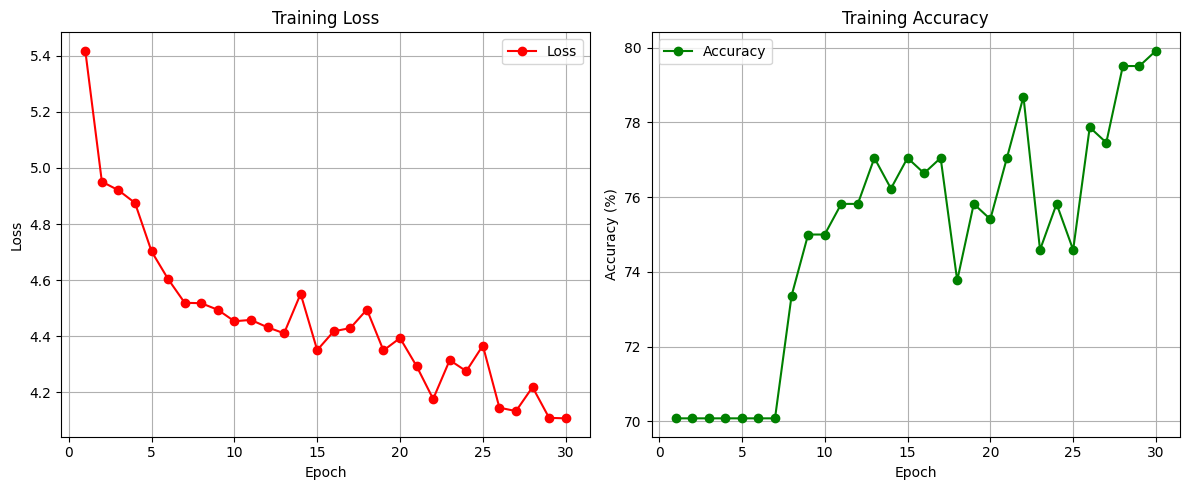

✅ Model Accuracy on Test Data: 72.58%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# ✅ Load Data
def load_data():
    train_data = np.load("train_data.npy")
    train_labels = np.load("train_labels.npy")
    test_data = np.load("test_data.npy")
    test_labels = np.load("test_labels.npy")

    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    return train_data, train_labels, test_data, test_labels

# ✅ Normalize using train mean/std
def normalize_data(data, mean=None, std=None):
    if mean is None or std is None:
        mean = data.mean(dim=(0, 1), keepdim=True)
        std = data.std(dim=(0, 1), keepdim=True)
    return (data - mean) / (std + 1e-8), mean, std

# ✅ CNN-LSTM Fusion Model
class FusedCNNLSTM(nn.Module):
    def __init__(self, input_channels=18, hidden_size=128, num_classes=2):
        super(FusedCNNLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.lstm1 = nn.LSTM(64, hidden_size, batch_first=True, bidirectional=True)

        self.conv2 = nn.Conv1d(hidden_size * 2, 128, kernel_size=3, padding=1)
        self.lstm2 = nn.LSTM(128, hidden_size, batch_first=True, bidirectional=True)

        self.conv3 = nn.Conv1d(hidden_size * 2, 256, kernel_size=3, padding=1)
        self.lstm3 = nn.LSTM(256, hidden_size, batch_first=True, bidirectional=True)

        self.conv4 = nn.Conv1d(hidden_size * 2, 256, kernel_size=3, padding=1)
        self.lstm4 = nn.LSTM(256, hidden_size, batch_first=True, bidirectional=True)

        self.conv5 = nn.Conv1d(hidden_size * 2, 512, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = x.permute(0, 2, 1)

        x = F.leaky_relu(self.conv1(x))
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x = x.permute(0, 2, 1)

        x = F.leaky_relu(self.conv2(x))
        x = x.permute(0, 2, 1)
        x, _ = self.lstm2(x)
        x = x.permute(0, 2, 1)

        x = F.leaky_relu(self.conv3(x))
        x = x.permute(0, 2, 1)
        x, _ = self.lstm3(x)
        x = x.permute(0, 2, 1)

        x = F.leaky_relu(self.conv4(x))
        x = x.permute(0, 2, 1)
        x, _ = self.lstm4(x)
        x = x.permute(0, 2, 1)

        x = F.leaky_relu(self.conv5(x))
        x = self.pool(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.zeros_(param)

# ✅ Training Function
def train_model(model, train_loader, epochs=30):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    all_losses = []
    all_accuracies = []

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        all_losses.append(total_loss)
        all_accuracies.append(accuracy)
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Accuracy: {accuracy:.2f}% | LR: {scheduler.get_last_lr()[0]:.6f}")

    torch.save(model.state_dict(), "gait_fused_cnn_lstm_1.pth")
    print("✅ Model Saved: gait_fused_cnn_lstm_1.pth")

    return all_losses, all_accuracies

# ✅ Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"✅ Model Accuracy on Test Data: {accuracy:.2f}%")
    return accuracy

# ✅ Plotting Function
def plot_training_curve(losses, accuracies):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, 'r-o', label='Loss')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, 'g-o', label='Accuracy')
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# ✅ Main Script
if __name__ == "__main__":
    train_data, train_labels, test_data, test_labels = load_data()

    # Print label distributions for debugging
    print("Train label distribution:", torch.bincount(train_labels))
    print("Test label distribution: ", torch.bincount(test_labels))

    train_data, mean, std = normalize_data(train_data)
    test_data, _, _ = normalize_data(test_data, mean, std)

    train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=32, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FusedCNNLSTM(input_channels=train_data.shape[2]).to(device)

    losses, accs = train_model(model, train_loader, epochs=30)
    plot_training_curve(losses, accs)
    evaluate_model(model, test_loader)


In [ ]:
import torch

# Replace with your actual file path
model_data = torch.load("gait_fused_cnn_lstm.pth", map_location="cpu")

if isinstance(model_data, dict):
    print("Top-level keys in the checkpoint:")
    for key in model_data.keys():
        print("-", key)
else:
    print("Loaded object type:", type(model_data))


Top-level keys in the checkpoint:
- conv1.weight
- conv1.bias
- lstm1.weight_ih_l0
- lstm1.weight_hh_l0
- lstm1.bias_ih_l0
- lstm1.bias_hh_l0
- lstm1.weight_ih_l0_reverse
- lstm1.weight_hh_l0_reverse
- lstm1.bias_ih_l0_reverse
- lstm1.bias_hh_l0_reverse
- conv2.weight
- conv2.bias
- lstm2.weight_ih_l0
- lstm2.weight_hh_l0
- lstm2.bias_ih_l0
- lstm2.bias_hh_l0
- lstm2.weight_ih_l0_reverse
- lstm2.weight_hh_l0_reverse
- lstm2.bias_ih_l0_reverse
- lstm2.bias_hh_l0_reverse
- conv3.weight
- conv3.bias
- lstm3.weight_ih_l0
- lstm3.weight_hh_l0
- lstm3.bias_ih_l0
- lstm3.bias_hh_l0
- lstm3.weight_ih_l0_reverse
- lstm3.weight_hh_l0_reverse
- lstm3.bias_ih_l0_reverse
- lstm3.bias_hh_l0_reverse
- conv4.weight
- conv4.bias
- lstm4.weight_ih_l0
- lstm4.weight_hh_l0
- lstm4.bias_ih_l0
- lstm4.bias_hh_l0
- lstm4.weight_ih_l0_reverse
- lstm4.weight_hh_l0_reverse
- lstm4.bias_ih_l0_reverse
- lstm4.bias_hh_l0_reverse
- conv5.weight
- conv5.bias
- fc.weight
- fc.bias


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# ✅ Load Data
def load_data():
    train_data = np.load("train_data.npy")
    train_labels = np.load("train_labels.npy")
    test_data = np.load("test_data.npy")
    test_labels = np.load("test_labels.npy")

    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    return train_data, train_labels, test_data, test_labels

# ✅ Normalize Data (Min-Max Scaling)
def normalize_data(data):
    mean = data.mean(dim=(0, 1), keepdim=True)
    std = data.std(dim=(0, 1), keepdim=True)
    return (data - mean) / (std + 1e-8)

# ✅ Fusion Model (CNN + LSTM alternately stacked)
class FusedCNNLSTM(nn.Module):
    def __init__(self, input_channels=18, hidden_size=128, num_classes=2):
        super(FusedCNNLSTM, self).__init__()
        self.hidden_size = hidden_size

        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.lstm1 = nn.LSTM(64, hidden_size, num_layers=1, batch_first=True, bidirectional=True)

        self.conv2 = nn.Conv1d(hidden_size * 2, 128, kernel_size=3, padding=1)
        self.lstm2 = nn.LSTM(128, hidden_size, num_layers=1, batch_first=True, bidirectional=True)

        self.conv3 = nn.Conv1d(hidden_size * 2, 256, kernel_size=3, padding=1)
        self.lstm3 = nn.LSTM(256, hidden_size, num_layers=1, batch_first=True, bidirectional=True)

        self.conv4 = nn.Conv1d(hidden_size * 2, 256, kernel_size=3, padding=1)
        self.lstm4 = nn.LSTM(256, hidden_size, num_layers=1, batch_first=True, bidirectional=True)

        self.conv5 = nn.Conv1d(hidden_size * 2, 512, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, channels, seq_len)

        x = F.leaky_relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # (batch, seq_len, channels)
        x, _ = self.lstm1(x)
        x = x.permute(0, 2, 1)

        x = F.leaky_relu(self.conv2(x))
        x = x.permute(0, 2, 1)
        x, _ = self.lstm2(x)
        x = x.permute(0, 2, 1)

        x = F.leaky_relu(self.conv3(x))
        x = x.permute(0, 2, 1)
        x, _ = self.lstm3(x)
        x = x.permute(0, 2, 1)

        x = F.leaky_relu(self.conv4(x))
        x = x.permute(0, 2, 1)
        x, _ = self.lstm4(x)
        x = x.permute(0, 2, 1)

        x = F.leaky_relu(self.conv5(x))
        x = self.pool(x).squeeze(-1)
        x = self.dropout(x)
        out = self.fc(x)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            if isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.zeros_(param)

# ✅ Training Function (Using Cosine Annealing LR + Label Smoothing)
def train_model(model, train_loader, epochs=30):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Accuracy: {accuracy:.2f}% | LR: {scheduler.get_last_lr()[0]:.6f}")

    torch.save(model.state_dict(), "gait_fused_cnn_lstm2.pth")
    print("✅ Model Saved: gait_fused_cnn_lstm.pth")

# ✅ Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"✅ Model Accuracy on Test Data: {accuracy:.2f}%")

# ✅ Main Script
if __name__ == "__main__":
    train_data, train_labels, test_data, test_labels = load_data()
    train_data, test_data = normalize_data(train_data), normalize_data(test_data)

    train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=32, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FusedCNNLSTM(input_channels=train_data.shape[2]).to(device)

    train_model(model, train_loader, epochs=30)
    evaluate_model(model, test_loader)


Epoch 1/30 | Loss: 5.3949 | Accuracy: 56.15% | LR: 0.000488
Epoch 2/30 | Loss: 4.9589 | Accuracy: 70.08% | LR: 0.000453
Epoch 3/30 | Loss: 4.8568 | Accuracy: 70.08% | LR: 0.000399
Epoch 4/30 | Loss: 4.8513 | Accuracy: 70.08% | LR: 0.000331
Epoch 5/30 | Loss: 4.6280 | Accuracy: 70.08% | LR: 0.000255
Epoch 6/30 | Loss: 4.5474 | Accuracy: 70.08% | LR: 0.000179
Epoch 7/30 | Loss: 4.5034 | Accuracy: 70.49% | LR: 0.000111
Epoch 8/30 | Loss: 4.5312 | Accuracy: 74.59% | LR: 0.000057
Epoch 9/30 | Loss: 4.5675 | Accuracy: 76.23% | LR: 0.000022
Epoch 10/30 | Loss: 4.4271 | Accuracy: 75.82% | LR: 0.000010
Epoch 11/30 | Loss: 4.5000 | Accuracy: 75.00% | LR: 0.000022
Epoch 12/30 | Loss: 4.4604 | Accuracy: 75.41% | LR: 0.000057
Epoch 13/30 | Loss: 4.3942 | Accuracy: 75.41% | LR: 0.000111
Epoch 14/30 | Loss: 4.3865 | Accuracy: 76.64% | LR: 0.000179
Epoch 15/30 | Loss: 4.4010 | Accuracy: 73.77% | LR: 0.000255
Epoch 16/30 | Loss: 4.3203 | Accuracy: 76.23% | LR: 0.000331
Epoch 17/30 | Loss: 4.2958 | Accu

In [ ]:
model = FusedCNNLSTM(input_channels=12).to(device)
model.load_state_dict(torch.load("gait_fused_cnn_lstm.pth", map_location=device))
model.eval()


FusedCNNLSTM(
  (conv1): Conv1d(12, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm1): LSTM(64, 128, batch_first=True, bidirectional=True)
  (conv2): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm2): LSTM(128, 128, batch_first=True, bidirectional=True)
  (conv3): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm3): LSTM(256, 128, batch_first=True, bidirectional=True)
  (conv4): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm4): LSTM(256, 128, batch_first=True, bidirectional=True)
  (conv5): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=2, bias=True)
)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_with_confusion(model, test_loader, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
    print(f"✅ Test Accuracy: {acc:.2f}%\n")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))


✅ Test Accuracy: 70.97%

Confusion Matrix:
[[ 2 17]
 [ 1 42]]


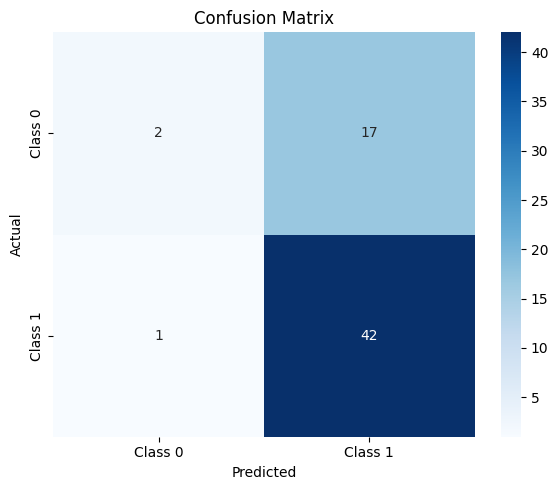


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.67      0.11      0.18        19
     Class 1       0.71      0.98      0.82        43

    accuracy                           0.71        62
   macro avg       0.69      0.54      0.50        62
weighted avg       0.70      0.71      0.63        62



In [ ]:
evaluate_model_with_confusion(model, test_loader, class_names=["Class 0", "Class 1"])
